In [1]:
%pip install gspread_pandas
%pip install fooddatacentral
%pip install pint
%pip install cufflinks

#Link to the deliverables https://github.com/ligonteaching/EEP153_Materials/blob/master/Project2/goals.pdf

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Configuration
from  scipy.optimize import linprog as lp
import numpy as np
import warnings
import pandas as pd
import eep153_tools
from eep153_tools.sheets import read_sheets
import fooddatacentral as fdc
import cufflinks as cf
cf.go_offline()
tol = 1e-5

apikey = 'XGLMhknvg8y65j7VpcMisC5nQrRGbdgqUe3GJRQY' 

#Test case to see if our APIKEY works
fdc.search(apikey,"marmite")
id =  2110211   # Put an FDC ID HERE!
fdc.nutrients(apikey,fdc_id=id)

,Quantity,Units
Total lipid (fat),3.53,g
"Vitamin C, total ascorbic acid",0.00,mg
"Vitamin A, IU",0.00,IU
Protein,8.24,g
"Carbohydrate, by difference",19.41,g
"Calcium, Ca",24.00,mg
Energy,141.00,kcal
"Sugars, total including NLEA",1.18,g
"Fatty acids, total trans",0.00,g
"Fatty acids, total saturated",0.88,g


In [3]:
#[A] Description of Population of Interest

print('Our group has decided to investigate the minimum cost diet of Berkeley students. We segmented our students into two possible routes: those who purchase meals with the food available on campus and those who cook with groceries off campus. We excluded students who eat out at restaurants because that is of a much higher budget range. The on-campus options included Golden Bear Cafe, Cafe Think, Rice & Bones, Goldie’s Coffee, Bears’ Lair, and Brown’s. We excluded freshman dining halls such as Crossroads because they are technically not on the school campus and only accept meal swipes and not the conventional form of currency. For off-campus groceries, we looked at both Trader Joe’s and Safeway, two of the biggest grocery chains nearby.')


Our group has decided to investigate the minimum cost diet of Berkeley students. We segmented our students into two possible routes: those who purchase meals with the food available on campus and those who cook with groceries off campus. We excluded students who eat out at restaurants because that is of a much higher budget range. The on-campus options included Golden Bear Cafe, Cafe Think, Rice & Bones, Goldie’s Coffee, Bears’ Lair, and Brown’s. We excluded freshman dining halls such as Crossroads because they are technically not on the school campus and only accept meal swipes and not the conventional form of currency. For off-campus groceries, we looked at both Trader Joe’s and Safeway, two of the biggest grocery chains nearby.


In [4]:
#[A] Data on Prices for Different Foods 

#Here we are loading the dataframes with information we collected for off and on-campus foods 
#df is our on-campus dataframe, df_offcampus is our off-campus dataframe
df = read_sheets("1O1JwxbaDF1ubq_OY2wPdsjVH9Kcn1xollVqG8bmDpbU",sheet="on_campus") 
df_offcampus = read_sheets("1O1JwxbaDF1ubq_OY2wPdsjVH9Kcn1xollVqG8bmDpbU",sheet='off_campus')

df = df.set_index('Food')
df_offcampus = df_offcampus.set_index('Food')

print('We collected data on prices for different foods sold off-campus and on-campus.')
df
df_offcampus

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
We collected data on prices for different foods sold off-campus and on-campus.


,Quantity,Units,Price,Date,Location,FDC
Food,,,,,,
Wheat Flour,80.0,oz,3.79,[2023-2-25],Safeway,789951
Eggs,408.0,grams,4.89,[2023-2-25],Safeway,747997
White Bread,22.0,oz,3.00,[2023-2-25],Safeway,325871
Whole Milk,1.0,gallon,5.99,[2023-2-25],Safeway,746782
Sliced Ham,14.0,oz,5.49,[2023-2-25],Safeway,332397
...,...,...,...,...,...,...
Canola Oil,24.0,oz,4.99,[2023-3-1],Safeway,748278
Butter,16.0,oz,5.99,[2023-3-1],Safeway,789828
Gouda Cheese,7.0,oz,4.79,[2023-3-1],Safeway,171241


In [5]:
#Here we are cleaning the data by: 

# Convert food quantities to FDC units
df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))
df['FDC Price'] = df['Price']/df['FDC Quantity'] # Dividing price by the FDC Quantity to get price per hectoliter
df.dropna(how='any') # Drop food with any missing data
Prices = df.groupby('Food')['FDC Price'].min()

#Off campus calulations to transfer to hectoliter
df_offcampus['FDC Quantity'] = df_offcampus[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))
df_offcampus['FDC Price'] = df_offcampus['Price']/df_offcampus['FDC Quantity']
df_offcampus.dropna(how='any') # Drop food with any missing data
Prices_off = df_offcampus.groupby('Food')['FDC Price'].min()


#These two variables show the prices per food off and on campus in hectoliters 
df
df_offcampus

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



,Quantity,Units,Price,Date,Location,FDC,FDC Quantity,FDC Price
Food,,,,,,,,
Wheat Flour,80.0,oz,3.79,[2023-2-25],Safeway,789951,22.679618500000004 hectogram,0.16711039473613717 / hectogram
Eggs,408.0,grams,4.89,[2023-2-25],Safeway,747997,4.08 hectogram,1.1985294117647058 / hectogram
White Bread,22.0,oz,3.00,[2023-2-25],Safeway,325871,6.236895087500001 hectogram,0.48100857203973285 / hectogram
Whole Milk,1.0,gallon,5.99,[2023-2-25],Safeway,746782,37.85411783999999 deciliter,0.15823905936253096 / deciliter
Sliced Ham,14.0,oz,5.49,[2023-2-25],Safeway,332397,3.9689332375000004 hectogram,1.383243222165689 / hectogram
...,...,...,...,...,...,...,...,...
Canola Oil,24.0,oz,4.99,[2023-3-1],Safeway,748278,6.80388555 hectogram,0.7334044588683594 / hectogram
Butter,16.0,oz,5.99,[2023-3-1],Safeway,789828,4.535923700000001 hectogram,1.3205689504874165 / hectogram
Gouda Cheese,7.0,oz,4.79,[2023-3-1],Safeway,171241,1.9844666187500002 hectogram,2.413746824835574 / hectogram


In [6]:
#[A] Nutritional Content of Different Foods

#mapping food quantities to nutrients for df 
import warnings
D = {}
count = 0
for food in df.index:
    try:
        FDC_on = df.loc[df.index==food,:].FDC.values[0]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC_on).Quantity
        print(food)
    except AttributeError:
        warnings.warn(f"Couldn't find FDC Code {FDC_on} for food {food}.")
D = pd.DataFrame(D,dtype=float)


#mapping food quantities to nutrients for df_offcampus
D_off = {}
count_off = 0
for food in  df_offcampus.index:
    try:
        FDC_off = df_offcampus.loc[df_offcampus.index==food,:].FDC.values[0]
        count_off+=1
        D_off[food] = fdc.nutrients(apikey,FDC_off).Quantity
        print(food)
    except AttributeError:
        warnings.warn(f"Couldn't find FDC Code {FDC_off} for food {food}.")
D_off = pd.DataFrame(D_off,dtype=float)

#Following US nutrition reccomendations segmented by gender and age,
    # these are the max and min tables for on-campus and off-campus populations 
RDIs = read_sheets('https://docs.google.com/spreadsheets/d/1vJ_Hvtg8Nccr640W-LW54yFVclkTvbiWHQ3JLYmEqEM/edit?usp=sharing')
bmin = RDIs['diet_minimums'].set_index('Nutrition')
bmin = bmin.drop('Source',axis=1)
bmax = RDIs['diet_maximums'].set_index('Nutrition')
bmax = bmax.drop('Source',axis=1)


RDIs2 = read_sheets('https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/')
bmin_off = RDIs2['diet_minimums'].set_index('Nutrition')
bmin_off = bmin_off.drop('Source',axis=1)
bmax_off = RDIs2['diet_maximums'].set_index('Nutrition')
bmax_off = bmax_off.drop('Source',axis=1)

D
D_off

Turkey & Swiss Sandwich
Caprese Panini
Chicken Paprika
Thai Marinated chicken Bahn Mi
French Fries
Black Beans & Corn Quesadilla 
Chicken Quesadilla 
Panko Crusted Fried Chicken Sandwich
Think Grass Fed Burger
Ham & Cheese Croissant
Banana
Chocolate Croissant
Banana Muffin
Tropical Hibusicus Green Tea
Drip Coffee (Reg or Decaf)
Espresso
Americano
Cappuccino
Latte
Caramel Macchiato
Hot Chocolate
Steamed Milk
Hot Tea
Chef Salad
Tropical Fruit Bowl
Raspberry Chobani Greek Yogurt 
Strawberry Banana Naked Juice 
Yerbamate
Winter Chopped Salad
Kale & Beets
Vegetable Cassoulet
Roast Chicken Breast
King Salmon & French Lentils
Beef Bourguignon
Chocolate Cake
Steamed Veggie Bun
Steamed Chicken Bun
Veggie Spring Rolls
Vietnamese Coffee
Vegan Pho 
Hibiscus Lemonade
Breakfast Burrito
Bacon Burrito
Turkey Sausage Burrito 
Breakfast Egg Croissant 
Bacon Croissant 
Turkey Saussage Croissant 
Hash Brown Patties
Small Fruit Cup
Philly Cheesesteak
Cheeseburger
Beyond Burger
Fried Chicken Sandwhich
Salmo

/tmp/ipykernel_57/1167989445.py:14: UserWarning:

Couldn't find FDC Code 2300695 for food Salmon Larb Bowl.



Buffalo Chicken Salad
California Greens Salad
Buffalo Chicken Loaded Fries
Cross Cut Fries


/tmp/ipykernel_57/1167989445.py:14: UserWarning:

Couldn't find FDC Code 2304126 for food Side Green Salad.



Large Fruit Salad
Regular Coffee
Decaf Coffee
Hot Tea
Orange Juice
Milk
Rotisserie Tri Tip
Roasted Chicken Breast
Seared Salmon Fillet
Seared Tofu


/tmp/ipykernel_57/1167989445.py:14: UserWarning:

Couldn't find FDC Code 2304126 for food Salad Seasonal Greens.



Garlic Fries
Vegetable Medley
Heriloom Grains
Brown Rice
Wheat Flour
Eggs
White Bread
Whole Milk
Sliced Ham
Salad Greens
Banana
Chicken Breasts
Coffee Roast
Tortillas
Salmon
Tomato
Blueberry Muffin
Russet Potatoes
Chicken Noodle Canned Soup
Canned Corn
Broccoli
Apple
Pasta (Rotini)
Sausage
Carrot
Yellow Onion
Lentils
Whole Milk
Spinach
Sweet Potato
Russet Potato
Beets
Sugar
Flour
Black Beans
Eggs
Banana
White Bread
Chicken Breast
Salmon
Tofu
Jasmine Rice
Salad Mix
Spaghetti
Ground Coffee
Claw Blue Swimming Crab Meat
Waterfront Bistro Crabmeat Imitation Chunk Style Fully Cooked
Waterfront Bistro Crabmeat Imitation Flake Style Fully Cooked
Waterfront Bistro Salmon Nova Atlantic Smoked Cold 
Waterfront Bistro Salmon Nova Atlantic Lox Ny Style
Waterfront Bistro Salmon Nova Atlantic Smoked Party Wheel 
Waterfront Bistro Salmon Atlantic Pastrami Style Smoked Cold
Waterfront Bistro Alaskan Cod Fillet Wild Caught 
Waterfront Bistro Salmon Wild Alaskan Sockeye Smoked Peppered 
Waterfront Bistro

,Wheat Flour,Eggs,White Bread,Whole Milk,Sliced Ham,Salad Greens,Banana,Chicken Breasts,Coffee Roast,Tortillas,...,Signature Farms Brussels Sprouts,Signature Farms Carrot Chips,Peanut Butter,Almonds,Sauerkraut,Canola Oil,Butter,Gouda Cheese,Sour Cream,Sunflower Seeds
"Ergosta-5,7-dienol",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Ergosta-7,22-dienol",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25-hydroxycholecalciferol,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alanine,NaN,0.714,NaN,0.11,NaN,NaN,NaN,NaN,NaN,0.169,...,NaN,NaN,1.16,0.98,0.03,NaN,NaN,0.762,NaN,NaN
"Alcohol, ethyl",NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.000,...,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cis-Lutein/Zeaxanthin,NaN,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cis-Lycopene,NaN,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cis-beta-Carotene,NaN,NaN,NaN,2.00,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trans-Lycopene,NaN,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Objective function to find the prices where quantities are all 100g
p = Prices.apply(lambda x:x.magnitude).dropna()
# Compile list that we have both prices and nutritional info for; drop if either missing
use = p.index.intersection(D.columns)
p = p[use]

#Maps bag of groceries x into nutrients, dropping nutritional information for foods we don't know the price of,
# and replace missing nutrients with zeros.
Aall = D[p.index].fillna(0)
# Drop rows of A that we don't have constraints for.
Amin = Aall.loc[bmin.index]
Amax = Aall.loc[bmax.index]
# Maximum requirements involve multiplying constraint by -1 to make <=.
A = pd.concat([Amin,-Amax])
b = pd.concat([bmin,-bmax])


#Objective function to find the prices where quantities are all 100g
p_off = Prices_off.apply(lambda x:x.magnitude).dropna()
use_off = p_off.index.intersection(D_off.columns)
p_off = p_off[use_off]

Aall_off = D_off[p_off.index].fillna(0)
Amin_off = Aall_off.loc[bmin_off.index]
Amax_off = Aall_off.loc[bmax_off.index]
A_off = pd.concat([Amin_off,-Amax_off])
b_off = pd.concat([bmin_off,-bmax_off])

In [8]:
#[A] Dietary Reference Intakes 
#takes age and sex, returns pandas series of data reference intakes of a variety of nutrients 

#helper function
def helper(age, sex): 
    if (age < 4) or (sex == 'C'):
        group = 'C 1-3'
    elif age < 9: 
        group = str(sex) + ' 4-8'
    elif age < 14:
        group = str(sex) + ' 9-13'
    elif age < 19:
        group = str(sex) + ' 14-18'
    elif age < 31:
        group = str(sex) + ' 19-30'
    elif age < 51:
        group = str(sex) + ' 31-50'
    else: # over 51: 
        group = str(sex) + ' 51+'
    return group


def dietary_ref_index(age, sex):
    group = helper(age, sex)
    series = np.abs(b[group])
    return series 

dietary_ref_index(22, 'M') #this should return the Pandas Series

Nutrition
Energy                            2400.0
Protein                             56.0
Fiber, total dietary                33.6
Folate, DFE                        400.0
Calcium, Ca                       1000.0
Carbohydrate, by difference        130.0
Iron, Fe                             8.0
Magnesium, Mg                      400.0
Niacin                              16.0
Phosphorus, P                      700.0
Potassium, K                      4700.0
Riboflavin                           1.3
Thiamin                              1.2
Vitamin A, RAE                     900.0
Vitamin B-12                         2.4
Vitamin B-6                          1.3
Vitamin C, total ascorbic acid      90.0
Vitamin E (alpha-tocopherol)        15.0
Vitamin K (phylloquinone)          120.0
Zinc, Zn                            11.0
Sodium, Na                        4600.0
Energy                            6200.0
Name: M 19-30, dtype: float64

In [9]:
#A Minimum Cost Diet Function 

groupM =  helper(22, 'M')
groupF =  helper(22, 'F')


resultM = lp(p, -A, -b[groupM], method='interior-point') #male on campus
resultF = lp(p, -A, -b[groupF], method='interior-point') #female on campus

result_Moff = lp(p_off, -A_off, -b_off[groupM], method='interior-point') #male off
result_Foff = lp(p_off, -A_off, -b_off[groupF], method='interior-point') #female off


#Print for the cost per day 
print(f"Cost of diet for {groupM} is ${resultM.fun:.2f} per day when dining on campus.") 
print(f"Cost of diet for {groupF} is ${resultF.fun:.2f} per day when dining on campus.")

print(f"Cost of diet for {groupM} is ${result_Moff.fun:.2f} per day off campus.")
print(f"Cost of diet for {groupF} is ${result_Foff.fun:.2f} per day off campus.")

Cost of diet for M 19-30 is $36.08 per day when dining on campus.
Cost of diet for F 19-30 is $30.62 per day when dining on campus.
Cost of diet for M 19-30 is $4.71 per day off campus.
Cost of diet for F 19-30 is $4.02 per day off campus.


In [10]:
#[A] Solution
#Print for what you will be eating 
dietfcamp = pd.Series(resultF.x,index=p.index)

#Females On-campus
print("\nFemales on campus will be eating (in 100s of grams or milliliters):")
print(dietfcamp[dietfcamp >= tol])  # Drop items with quantities less than precision of calculation.

#Males On-campus
dietmcamp = pd.Series(resultM.x,index=p.index)
print("\nMales on campus will be eating (in 100s of grams or milliliters):")
print(dietmcamp[dietmcamp >= tol]) 

#Females Off-campus
dietfoff = pd.Series(result_Foff.x,index=p_off.index)
print("\nFemales off campus will be eating (in 100s of grams or milliliters):")
print(dietfoff[dietfoff >= tol]) 

#Males Off-campus
dietmoff = pd.Series(result_Moff.x,index=p_off.index)
print("\nMales off campus will be eating (in 100s of grams or milliliters):")
print(dietmoff[dietmoff >= tol]) 

print(dietmcamp)


Females on campus will be eating (in 100s of grams or milliliters):
Banana Muffin              3.446857
Chocolate Croissant        5.603448
Decaf Coffee               0.548026
Fried Chicken Sandwhich    2.700120
Milk                       2.317525
Orange Juice               2.164611
Vegetable Medley           0.198955
dtype: float64

Males on campus will be eating (in 100s of grams or milliliters):
Banana Muffin              3.572513
Chocolate Croissant        5.886194
Decaf Coffee               0.361106
Fried Chicken Sandwhich    2.364292
Milk                       1.813233
Orange Juice               3.178660
Vegetable Medley           2.197042
Yerbamate                  0.353543
dtype: float64

Females off campus will be eating (in 100s of grams or milliliters):
Black Beans      1.345129
Canola Oil       0.592932
Flour            0.827400
Lentils          1.216704
Navel Oranges    0.797667
Peanut Butter    0.475237
Salad Greens     2.111576
Whole Milk       4.444444
dtype: float64



In [11]:
#substistance problem function
def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices
    p = p.dropna()
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]
    Aall = FoodNutrients[p.index].fillna(0)
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    A = pd.concat([Amin, -Amax])
    b = pd.concat([dietmin, -dietmax]) 
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)
    
    if max_weight is not None:
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
    result = lp(p, -A, -b, method='interior-point')
    result.A = A
    result.b = b
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  
    return result

In [12]:
#[B] Total Cost for Population of Interest 

total_undergrad = 32479
percent_berkeley_male = .43668
percent_berkeley_female = .55483

count_berkeley_male = percent_berkeley_male * total_undergrad
count_berkeley_female = percent_berkeley_female * total_undergrad

price_campus_male = count_berkeley_male * resultM.fun
price_campus_female = count_berkeley_female * resultF.fun

price_offcampus_male = count_berkeley_male * result_Moff.fun
price_offcampus_female = count_berkeley_female * result_Foff.fun

print(f"Total cost of diet for the Berkeley Male Population is ${price_campus_male} per day when dining on campus.") 
print(f"Total cost of diet for the Berkeley Female Population is ${price_campus_female} per day when dining on campus.") 

print(f"Total cost of diet for the Berkeley Male Population is ${price_offcampus_male} per day when dining off campus.") 
print(f"Total cost of diet for the Berkeley Female Population is ${price_offcampus_female} per day when dining off campus.") 


Total cost of diet for the Berkeley Male Population is $511745.05027386185 per day when dining on campus.
Total cost of diet for the Berkeley Female Population is $551710.3045041191 per day when dining on campus.
Total cost of diet for the Berkeley Male Population is $66867.85639826843 per day when dining off campus.
Total cost of diet for the Berkeley Female Population is $72506.7058299956 per day when dining off campus.


In [13]:
#[B] Is the Solution Edible ?

print('Meal options are limited with these ingredients. If a student was really struggling with finances, they could make a “struggle meal” out of these foods, but the taste may not be as appealing as the more expensive, on-campus solution.')

Meal options are limited with these ingredients. If a student was really struggling with finances, they could make a “struggle meal” out of these foods, but the taste may not be as appealing as the more expensive, on-campus solution.


In [14]:
#cleaning data for sensitivity

df.dropna(how='any')
Prices = df.groupby('Food',sort=False)['FDC Price'].min()
df_offcampus.dropna(how='any') # Drop food with any missing data
Prices_off = df_offcampus.groupby('Food',sort=False)['FDC Price'].min()
df

,Quantity,Units,Price,Date,Location,FDC,FDC Quantity,FDC Price
Food,,,,,,,,
Turkey & Swiss Sandwich,250.0,grams,11.25,[2023-2-23],Cafe Think,2342427,2.5 hectogram,4.5 / hectogram
Caprese Panini,250.0,grams,11.25,[2023-2-23],Cafe Think,468080,2.5 hectogram,4.5 / hectogram
Chicken Paprika,250.0,grams,11.25,[2023-2-23],Cafe Think,1952920,2.5 hectogram,4.5 / hectogram
Thai Marinated chicken Bahn Mi,250.0,grams,12.25,[2023-2-23],Cafe Think,2463885,2.5 hectogram,4.9 / hectogram
French Fries,250.0,grams,4.75,[2023-2-23],Cafe Think,169833,2.5 hectogram,1.9 / hectogram
...,...,...,...,...,...,...,...,...
Salad Seasonal Greens,190.0,grams,4.00,[2023-2-24],Brown's,2304126,1.9000000000000001 hectogram,2.1052631578947367 / hectogram
Garlic Fries,100.0,grams,4.00,[2023-2-24],Brown's,1912834,1.0 hectogram,4.0 / hectogram
Vegetable Medley,150.0,grams,4.00,[2023-2-24],Brown's,2133291,1.5 hectogram,2.6666666666666665 / hectogram


Effect of Price on Changes on in Females On Campus's Substistence Diet Cost


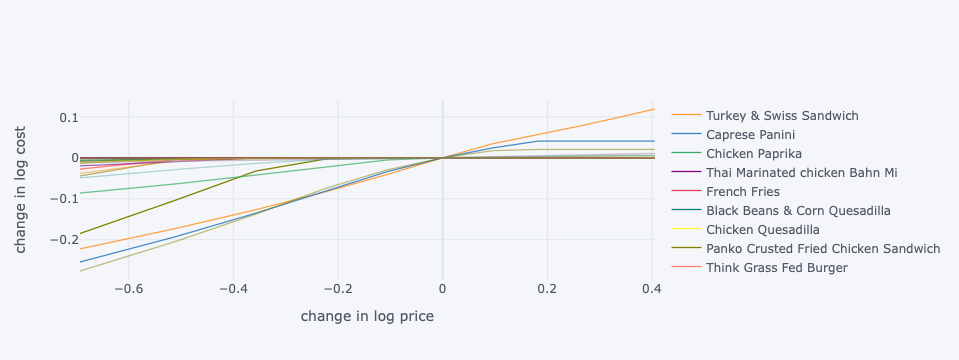

Effect of Price on Changes on in Males On Campus's Substistence Diet Cost


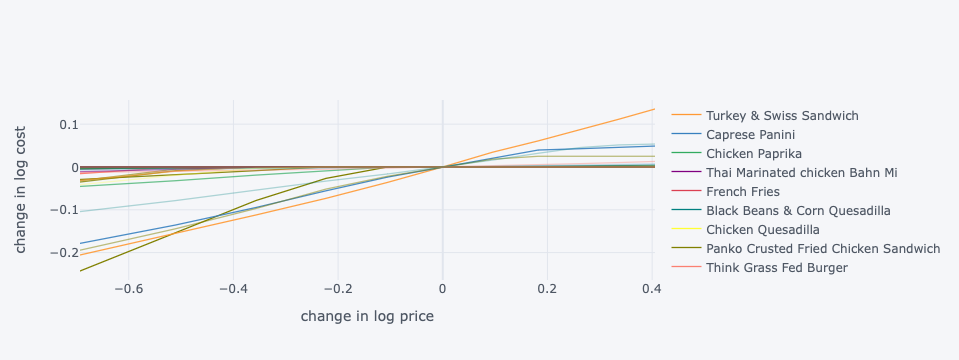

Effect of Price on Changes on in Females Off Campus's Substistence Diet Cost


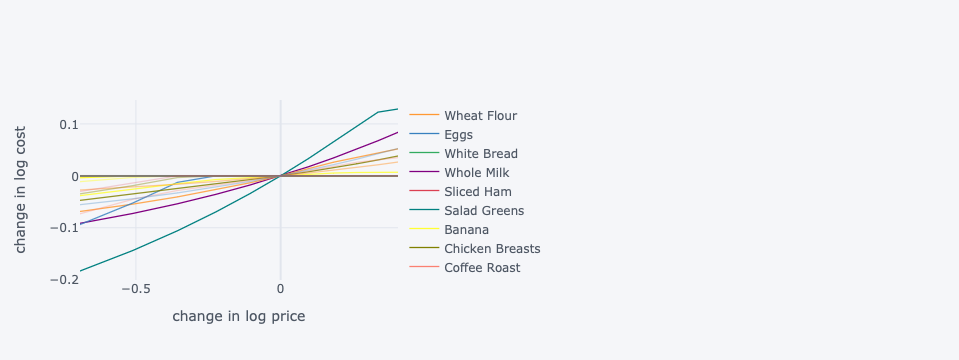

Effect of Price on Changes on in Males Off Campus's Substistence Diet Cost


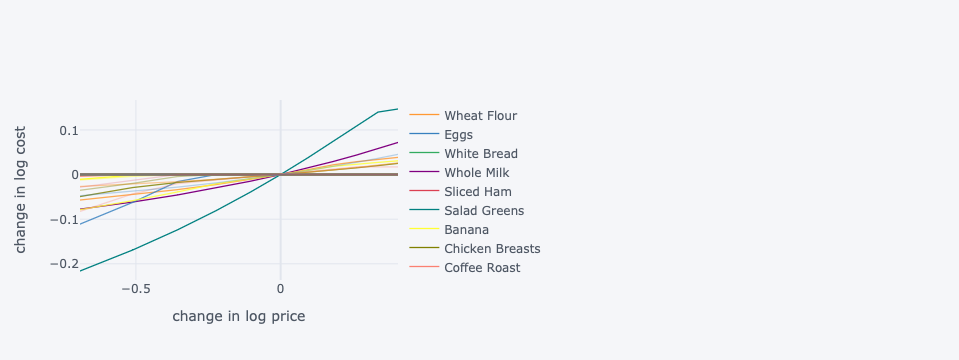

In [17]:
#[C] Sensitivity of Solution
import cufflinks as cf
cf.go_offline()

def sense_solution(df, price, diet_min, diet_max, group):
    scale = [.5,.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5]
    cost0 = solve_subsistence_problem(df,price,diet_min[group],diet_max[group],tol=tol).fun
    Price_response={}
    for s in scale:
        cost = {}
        for i,p in enumerate(price):
            my_p = price.copy()
            my_p[i] = p*s
            result = solve_subsistence_problem(df,my_p,diet_min[group],diet_max[group],tol=tol)
            
            cost[price.index[i]] = np.log(result.fun/cost0)
        Price_response[np.log(s)] = cost
    Price_response = pd.DataFrame(Price_response).T
    return Price_response.iplot(xTitle='change in log price',yTitle='change in log cost')
    
print(f"Effect of Price on Changes on in Females On Campus's Substistence Diet Cost") 
F_on_PR = sense_solution(D, Prices, bmin, bmax, groupF)
F_on_PR

print(f"Effect of Price on Changes on in Males On Campus's Substistence Diet Cost") 
M_on_PR = sense_solution(D, Prices, bmin, bmax, groupM)
M_on_PR

print(f"Effect of Price on Changes on in Females Off Campus's Substistence Diet Cost") 
F_off_PR = sense_solution(D_off, Prices_off, bmin_off, bmax_off, groupF)
F_off_PR

print(f"Effect of Price on Changes on in Males Off Campus's Substistence Diet Cost") 
M_off_PR = sense_solution(D_off, Prices_off, bmin_off, bmax_off, groupM)
M_off_PR

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



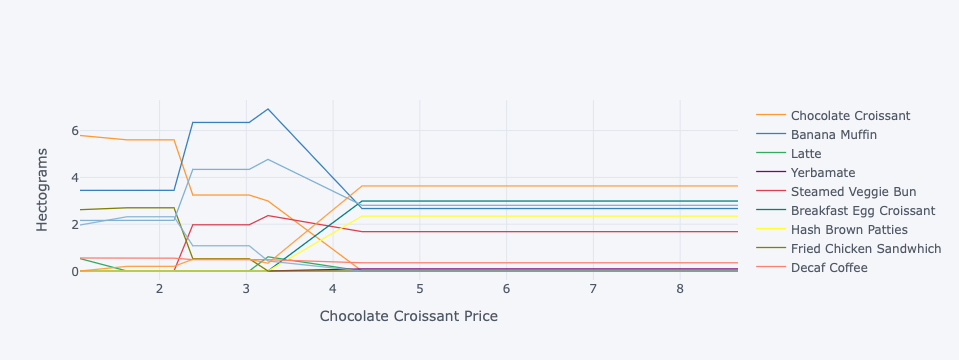

In [18]:
#Sensitivity of Solution for Females On Campus to Changes in Chocolocate Croissant Prices 
ReferenceGood = 'Chocolate Croissant'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(D,Prices,bmin[groupF],bmax[groupF],tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(D,my_p,bmin[groupF],bmax[groupF],tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')

/opt/conda/envs/anaconda-2022.05-py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



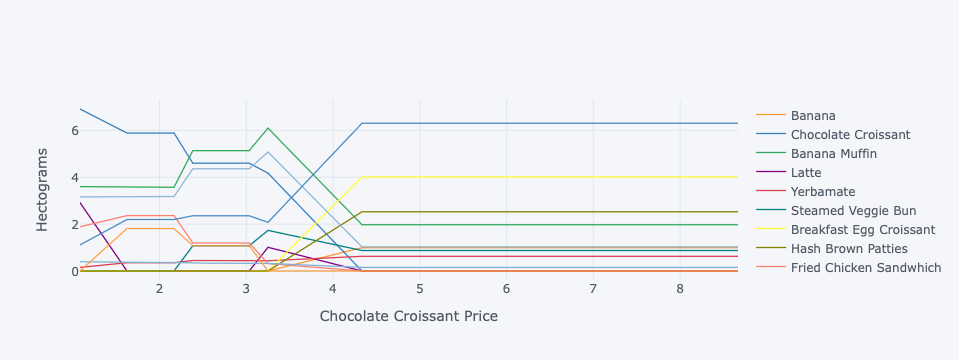

In [19]:
#Sensitivity of Solution for Males On Campus to Changes in Chocolocate Croissant Prices 
ReferenceGood = 'Chocolate Croissant'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(D,Prices,bmin[groupM],bmax[groupM],tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(D,my_p,bmin[groupM],bmax[groupM],tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')